# Toy Model 

## Basic Model



In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

In [95]:
def grad_U(data, theta, N, n):
    mu = theta[0]
    gamma = theta[1]

    sigma_x = np.sum(data)
    sigma_x2 = np.sum((data-mu)**2)

    d_mu = (N+1) * mu * gamma - gamma * N * sigma_x / n 
    d_gamma = 1 - (N+1)/(2*gamma) + mu**2/2 +N *sigma_x2 / (2*n)

    return np.array([d_mu, d_gamma])


def calculate_V(data, theta, N, n):

    g_theta_mean = grad_U(data, theta, N, n)

    V = np.zeros((2,2))

    for i in range(len(data)):
        g_theta_i = grad_U([data[i]], theta, N, n) - g_theta_mean
        V += np.outer(g_theta_i, g_theta_i)

    return V / (n-1)

def update_I(t, V, I_old):
    kappa = 1/t
    I_new = (1-kappa) * I_old + kappa*V
    return I_new

def update_p(p_old, h, U_theta, N, n, I_new, xi_old, A):
    p_new = p_old - U_theta * h - (h/2)* (N**2/n) * np.dot(I_new, p_old) * h - np.dot(xi_old, p_old) * h + np.sqrt(2*A*h) * np.random.normal(0, 1, 1)
    return p_new

def update_xi(xi_old, p_new, N_d, h):
    xi_new = xi_old +(np.dot(p_new, p_new) / N_d - 1) * h
    return xi_new


C:\Users\will-\AppData\Local\Temp\ipykernel_27256\1429693210.py:6: RuntimeWarning: overflow encountered in square
  sigma_x2 = np.sum((data-mu)**2)
C:\Users\will-\AppData\Local\Temp\ipykernel_27256\1429693210.py:8: RuntimeWarning: overflow encountered in scalar multiply
  d_mu = (N+1) * mu * gamma - gamma * N * sigma_x / n
C:\Users\will-\AppData\Local\Temp\ipykernel_27256\1429693210.py:9: RuntimeWarning: overflow encountered in scalar power
  d_gamma = 1 - (N+1)/(2*gamma) + mu**2/2 +N *sigma_x2 / (2*n)
C:\Users\will-\AppData\Local\Temp\ipykernel_27256\1429693210.py:21: RuntimeWarning: invalid value encountered in subtract
  g_theta_i = grad_U([data[i]], theta, N, n) - g_theta_mean


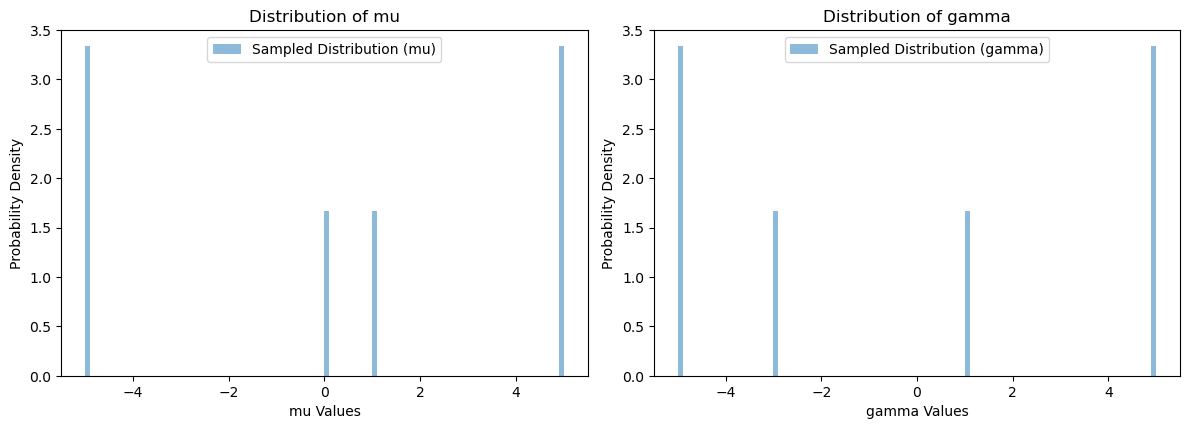

In [96]:
h = 0.01
A = 1
xi = A
theta = np.array([1,1])
p = np.array([1,1])
I = np.eye(2)

N_d = len(theta)

# Set the seed for reproducibility (optional)
#np.random.seed(42)

# Number of samples
N = 100

# Generate N samples from a standard normal distribution
data = np.random.normal(0, 1, N)

n = 20

# Arrays to store sampled values
mu_samples = []
gamma_samples = []

# Number of samples for plotting the true distribution
plot_samples = 10000

for t in range(1, 10000):
    x = data[np.random.randint(0, N, n)]
    theta = theta + p*h
    V = calculate_V(x, theta, N, n)
    I = update_I(t, V, I)
    U_theta = grad_U(x, theta, N, n)
    p = update_p(p, h, U_theta, N, n, I, xi, A)
    xi = update_xi(xi, p, N_d, h)

    # Collect samples for plotting
    if t % 1 == 0:
        mu_samples.append(theta[0])
        gamma_samples.append(theta[1])

# Apply clipping to limit the range of sampled values
mu_samples_clipped = np.clip(mu_samples, -5, 5)
gamma_samples_clipped = np.clip(gamma_samples, -5, 5)


# Plotting the marginal distributions of mu and gamma
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(mu_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (mu)')
plt.title('Distribution of mu')
plt.xlabel('mu Values')
plt.ylabel('Probability Density')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gamma_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (gamma)')
plt.title('Distribution of gamma')
plt.xlabel('gamma Values')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()


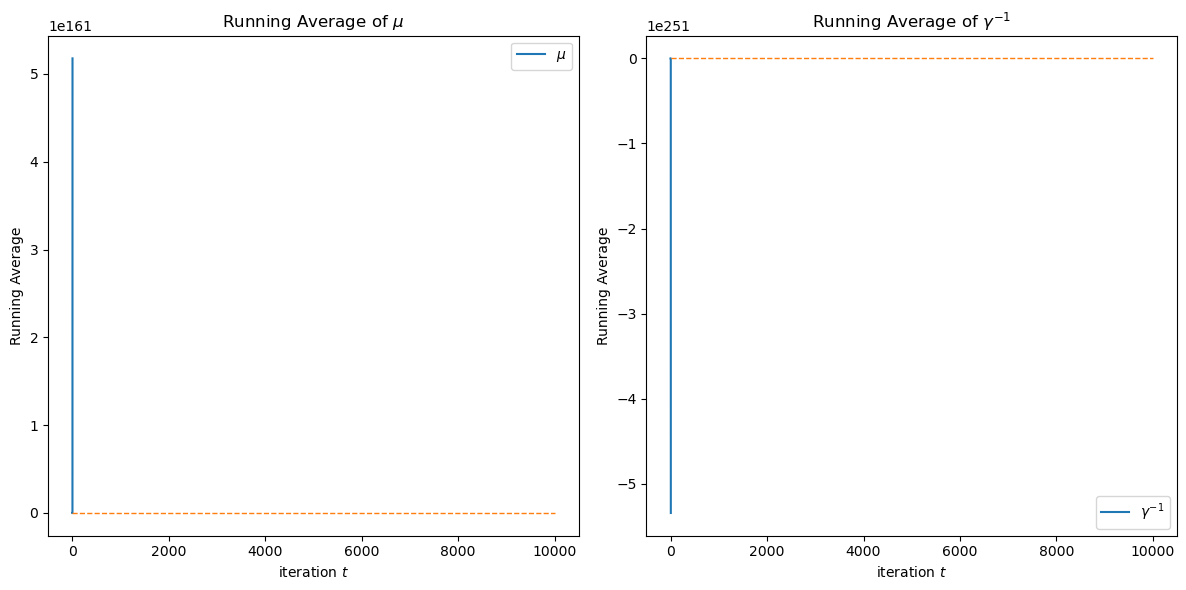

In [97]:
# Plot running averages of observables
plt.figure(figsize=(12, 6))

mu_samples = np.array(mu_samples)
gamma_samples = np.array(gamma_samples)

plt.subplot(1, 2, 1)
plt.plot(range(len(mu_samples)), np.cumsum(mu_samples) / (np.arange(len(mu_samples)) + 1), label='$\mu$')
plt.plot([1,len(mu_samples)], [np.mean(data), np.mean(data)], linewidth=1, linestyle='--')
plt.title('Running Average of $\mu$')
plt.xlabel('iteration $t$')
plt.ylabel('Running Average')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(gamma_samples)), np.cumsum(gamma_samples) / (np.arange(len(gamma_samples)) + 1), label='$\gamma^{-1}$')
plt.plot([1,len(mu_samples)], [1/np.std(data), 1/np.std(data)], linewidth=1, linestyle='--')
plt.title('Running Average of $\gamma^{-1}$')
plt.xlabel('iteration $t$')
plt.ylabel('Running Average')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
print(np.mean(mu_samples_clipped))
print(np.mean(gamma_samples_clipped))

print(np.mean(data))
print(1/np.std(data))

0.050526802105479496
1.180418880386934
0.04801476961642125
1.0900900260223025



## BAOAB Integrator 

*Model description*

In [1]:
import numpy as np

# Scalar
a = 2

# Vector
v = np.array([4, 2, 1])

# Divide scalar by vector
u = a / v

print("Scalar divided by vector:")
print(u)


Scalar divided by vector:
[0.5 1.  2. ]


In [29]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    
    return [q,p]

def B_step( qp , h, force ):
    q,p = qp
    
    p = p + h*force
    
    return [q,p]

def O_step( qp , h, phi, beta, A):
    q,p = qp
    
    alpha = np.exp(-h*phi)
    
    R = np.random.randn( q.size ).reshape( q.shape)
    p = alpha * p + np.sqrt(A/(beta*phi)) * np.sqrt(1-alpha ** 2) * R
    
    return [q,p]

In [90]:
def grad_U(data, theta, N, n):
    mu, gamma = theta

    sigma_x = np.sum(data)
    sigma_x2 = np.sum((data - mu)**2)

    d_mu = (N + 1) * mu * gamma - gamma * N * sigma_x / n 
    d_gamma = 1 - (N + 1) / (2 * gamma) + mu**2 / 2 + N * sigma_x2 / (2 * n)

    return [d_mu, d_gamma]


def run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n):
    q_traj = [q0]
    p_traj = [p0]
    t_traj = [0.0]

    xi = A
    I = np.eye(2)
    q = q0
    p = p0
    t = 0

    for i in range(Nsteps):
        idx = np.random.permutation(np.arange(N))[:n]
        data = Samples[idx]
        force = - np.array(grad_U(data, q, N, n))
        q, p, I, xi = step_function(q, p, h, A, beta, force, I, xi, data)
        t += h

        # push!(q_traj, copy(q))
        q_traj += [q]
        p_traj += [p]
        t_traj += [t]
        # push!(p_traj, copy(p))
        # push!(t_traj, t)

    return q_traj, p_traj, t_traj


def update_I(t, V, I_old):
    kappa = 1/t
    I_new = (1-kappa) * I_old + kappa*V
    return I_new

def update_xi(xi_old, p_new, N_d, h):
    xi_new = xi_old +(np.dot(p_new, p_new) / N_d - 1) * h
    return xi_new

def calculate_V(data, theta, N, n):

    g_theta_mean = grad_U(data, theta, N, n)

    V = np.zeros((2,2))

    for i in range(len(data)):
        g_theta_i = np.array(grad_U([data[i]], theta, N, n)) - g_theta_mean
        V += np.outer(g_theta_i, g_theta_i)

    return V / (n-1)

def BAuOuAB_step(q, p, h, A, beta, force, I, xi, data):
    qp = [q,p]

    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2)

    V = calculate_V(data, theta, N, n)
    I = update_I(t, V, I)
    phi = np.diag((h/2)*beta*(N**2/n) * I) + xi

    qp = O_step( qp , h, phi, beta, A)

    xi = update_xi(xi, qp[1], 2, h)
    
    qp = A_step(qp, h/2)
    qp = B_step(qp, h/2, force)
    q, p = qp
    return q, p, I, xi


In [91]:
# Initialize one walker from a Gaussian distribution
q0 = np.array([1,1])
p0 = np.array([1,1])

print(q0)
print(p0)

Nsteps = 10000
h = 0.01
A = 1
beta = 1.0
N = 100
n = 10
Samples = np.random.normal(0, 1, N)

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps, h, A, beta, Samples, BAuOuAB_step, grad_U, N, n)

[1 1]
[1 1]


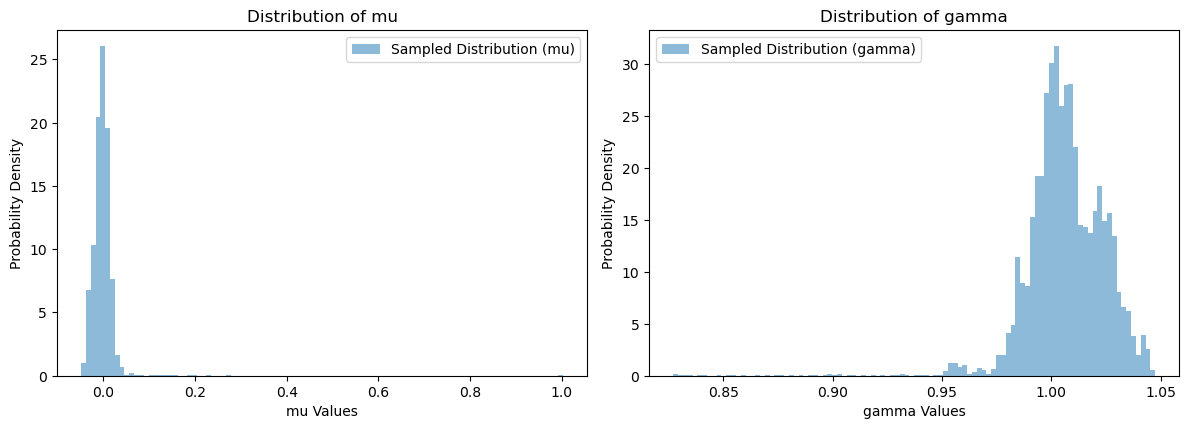

In [92]:
mu_samples = np.array(q_traj)[:,0]
gamma_samples = np.array(q_traj)[:,1]

# Apply clipping to limit the range of sampled values
mu_samples_clipped = np.clip(mu_samples, -5, 5)
gamma_samples_clipped = np.clip(gamma_samples, -5, 5)


# Plotting the marginal distributions of mu and gamma
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(mu_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (mu)')
plt.title('Distribution of mu')
plt.xlabel('mu Values')
plt.ylabel('Probability Density')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gamma_samples_clipped, bins=100, density=True, alpha=0.5, label='Sampled Distribution (gamma)')
plt.title('Distribution of gamma')
plt.xlabel('gamma Values')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

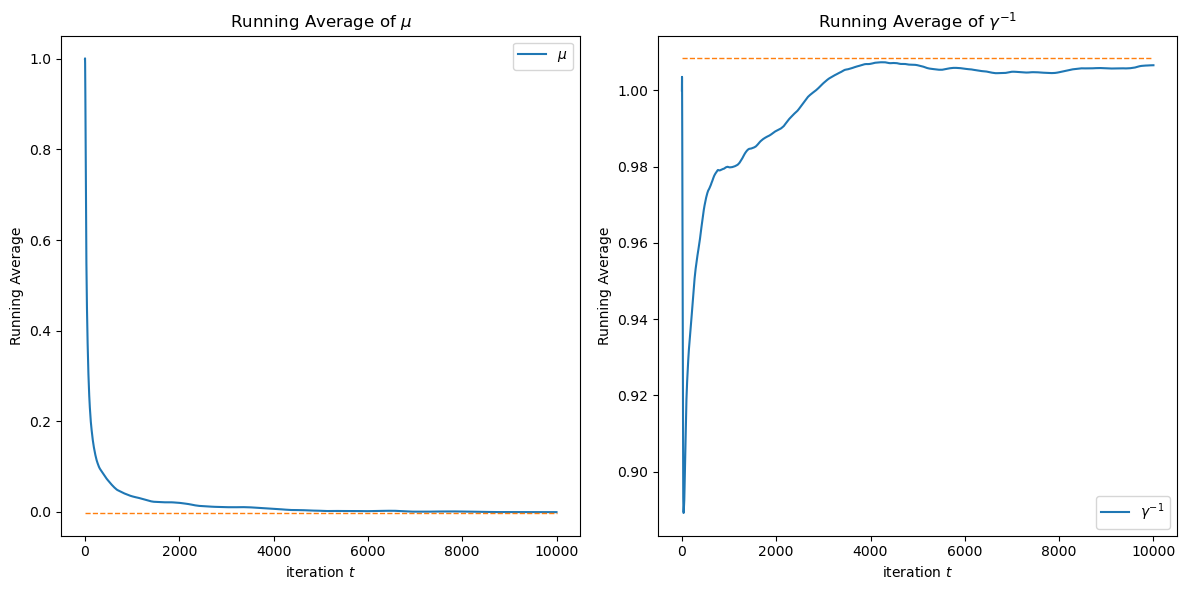

In [94]:
# Plot running averages of observables
plt.figure(figsize=(12, 6))

mu_samples = np.array(mu_samples)
gamma_samples = np.array(gamma_samples)

plt.subplot(1, 2, 1)
plt.plot(range(len(mu_samples)), np.cumsum(mu_samples) / (np.arange(len(mu_samples)) + 1), label='$\mu$')
plt.plot([1,len(mu_samples)], [np.mean(Samples), np.mean(Samples)], linewidth=1, linestyle='--')
plt.title('Running Average of $\mu$')
plt.xlabel('iteration $t$')
plt.ylabel('Running Average')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(gamma_samples)), np.cumsum(gamma_samples) / (np.arange(len(gamma_samples)) + 1), label='$\gamma^{-1}$')
plt.plot([1,len(mu_samples)], [1/np.std(Samples), 1/np.std(Samples)], linewidth=1, linestyle='--')
plt.title('Running Average of $\gamma^{-1}$')
plt.xlabel('iteration $t$')
plt.ylabel('Running Average')
plt.legend()

plt.tight_layout()
plt.show()